In [ ]:
from google.colab import drive          
drive.mount('/content/drive')
!pip install wfdb 
!pip install tqdm 
!pip install torchmetrics
!pip install seaborn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wfdb
from tqdm import tqdm
from wfdb import processing

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch.utils.data as data
import torchmetrics
from torchmetrics import AUROC
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader




from sklearn.preprocessing import LabelEncoder, normalize
#set gpu for device
device = torch.device("cpu" if torch.cuda.is_available() else "gpu") 
torch.cuda.is_available()

True

In [ ]:
#path of dataset file
path = '/content/drive/My Drive/ML/Dataset/Apnea/apnea-ecg-database-1.0.0/' 

## Plotting the record for a01

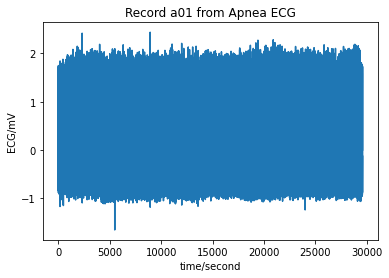

{'record_name': 'a01',
 'n_sig': 1,
 'fs': 100,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 2957000,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['ECG'],
 'p_signal': array([[-0.06 ],
        [-0.065],
        [-0.06 ],
        ...,
        [ 0.   ],
        [ 0.   ],
        [ 0.   ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['a01.dat'],
 'fmt': ['16'],
 'samps_per_frame': [1],
 'skew': [None],
 'byte_offset': [None],
 'adc_gain': [200.0],
 'baseline': [0],
 'units': ['mV'],
 'adc_res': [12],
 'adc_zero': [0],
 'init_value': [-12],
 'checksum': [5827],
 'block_size': [0]}

In [ ]:
path_a01 = path + str ('a01') 
record = wfdb.rdrecord(path_a01,channels= [0]) 
wfdb.plot_wfdb(record, title='Record a01 from Apnea ECG') 
display(record.__dict__)

## Plotting sample record for a01

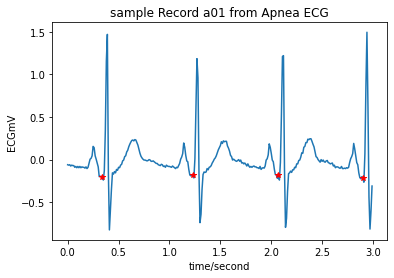

In [ ]:
record_sample = wfdb.rdrecord(path_a01, sampfrom=0, sampto=300)
annotation_sample = wfdb.rdann(path_a01, extension="qrs", sampfrom=0, sampto=300)
wfdb.plot_wfdb(
    record_sample,
    title="sample Record a01 from Apnea ECG",
    annotation=annotation_sample,
)

## Prepocessing the data for analysis


Function to bandpass the signals

In [ ]:
from scipy import signal


def bandpass_signal(xn, lower, upper):
    length = len(xn)
    t = np.linspace(-1, 1, length)

    b, a = signal.butter(3, [lower, upper], btype="bandpass", fs=100)

    zi = signal.lfilter_zi(b, a)

    z, _ = signal.lfilter(b, a, xn, zi=zi * xn[0])
    z2, _ = signal.lfilter(b, a, z, zi=zi * z[0])
    y = signal.filtfilt(b, a, xn)

    return y

Obtaining test and training datasets, and normalizing them


In [ ]:


ecg_readings = []
appnea_samples = []



train_files = [
    "b02",
    "c03",
    "b03",
    "c04",
    "b04",
    "a05",
    "c05",
    "a06",
    "c06",
    "a07",
    "c07",
    "a08",
    "c08",
    "a09",
    "a10",
    "a11",
    "a12",
    "a13",
    "a14",
    "a15",
    "a16",
    "b05",
    "c09",
    "c10",
    "a17",
    "a18",
    "a19",
    "a20",
]

# Iterate through the training files
for file in train_files:
    # Create the file path and read the record and apnea annotations
    path_dat = os.path.join(path, file)
    record = wfdb.rdrecord(path_dat)
    apnea = wfdb.rdann(path_dat, "apn")
    
    # Determine the length of the ECG segments to extract
    length = min(len(apnea.symbol) - 1, int((record.p_signal.shape[0] - 3000) / 6000))
    
    # Extract the ECG signal and apply a bandpass filter
    ecg = record.p_signal
    ecg = ecg.reshape(len(ecg))
    ecg_with_filter = bandpass_signal(ecg, 1, 48)
    
    # Extract the ECG segments and apnea labels
    for j in range(length):
        appnea_samples.append(apnea.symbol[j + 1])
        ecg_readings.append(ecg_with_filter[6000 * j + 3000 : 3000 + 6000 * (j + 1)])

# Convert the lists to numpy arrays
ecg_array_train = np.array(ecg_readings)
appnea_array_train = np.array(appnea_samples)

# Normalize the ECG data between -1 and 1
ecg_array_train = ecg_array_train.reshape(ecg_array_train.shape[0], ecg_array_train.shape[1])
ecg_array_train = normalize(ecg_array_train, norm="max")

# Encode the apnea labels as 0 and 1
appnea_array_train = LabelEncoder().fit_transform(appnea_array_train)


In [ ]:
ecg_readings = []
appnea_samples = []

test_files = ['b01','c01','c02','a01','a02','a03','a04']


# Iterate through the test files
for file in test_files:
    # Create the file path and read the record and apnea annotations
    path_dat = os.path.join(path, file)
    record = wfdb.rdrecord(path_dat, channels=[0])
    apnea = wfdb.rdann(path_dat, "apn")
    
    # Determine the length of the ECG segments to extract
    length = min(len(apnea.symbol) - 1, int((record.p_signal.shape[0] - 3000) / 6000))
    
    # Extract the ECG signal and apply a bandpass filter
    ecg = record.p_signal
    ecg = ecg.reshape(len(ecg))
    ecg_with_filter = bandpass_signal(ecg, 1, 48)
    
    # Extract the ECG segments and apnea labels
    for j in range(length):
        appnea_samples.append(apnea.symbol[j + 1])
        ecg_readings.append(ecg_with_filter[6000 * j + 3000 : 3000 + 6000 * (j + 1)])

# Convert the lists to numpy arrays
ecg_array_test = np.array(ecg_readings)
appnea_array_test = np.array(appnea_samples)

# Normalize the ECG data between -1 and 1
ecg_array_test = ecg_array_test.reshape(ecg_array_test.shape[0], ecg_array_test.shape[1])
ecg_array_test = normalize(ecg_array_test, norm="max")

# Encode the apnea labels as 0 and 1
appnea_array_test = LabelEncoder().fit_transform(appnea_array_test)


# **Building the model**

Setting the hyperparameters


In [ ]:
in_channels = 1
num_classes = 1
learning_rate = 0.001
batch_size = 128
num_epochs = 4

Converting the data to tensors

In [ ]:
torch.manual_seed(1)

X= torch.tensor (ecg_array_train,dtype =torch.float32 ).unsqueeze (1)
y = torch.tensor (appnea_array_train,dtype =torch.float32 ) 
x_test = torch.tensor (ecg_array_test,dtype =torch.float32 ).unsqueeze (1)
y_test = torch.tensor (appnea_array_test,dtype =torch.float32 )

train_dataset = TensorDataset(X,y)  
test_dataset = TensorDataset(x_test,y_test) 

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Training the model


In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels=0, num_classes=1):
        super(CNN, self).__init__()
        # First convolution layer to extract features from data
        self.conv1 = nn.Conv1d(
            in_channels=in_channels, out_channels=8, kernel_size=5, padding=2, stride=1
        )
        # Max pooling layer
        self.pool1 = nn.MaxPool1d(kernel_size=6, stride=6)
        
        # Second convolutional layer
        self.conv2 = nn.Conv1d(
            in_channels=8, out_channels=16, kernel_size=5, padding=2, stride=1
        )

        # Max pooling layer

        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Additionnal convolutional layers

        self.conv3 = nn.Conv1d(
            in_channels=16, out_channels=32, kernel_size=5, padding=2, stride=1
        )
        self.conv4 = nn.Conv1d(
            in_channels=32, out_channels=64, kernel_size=5, padding=2, stride=1
        )
        self.conv5 = nn.Conv1d(
            in_channels=64, out_channels=128, kernel_size=6, padding=2, stride=1
        )
        self.conv6 = nn.Conv1d(
            in_channels=128, out_channels=128, kernel_size=5, padding=2, stride=1
        )
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 31, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 1)
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        # Apply the ReLU activation function to the output of the first, second, 
        #third, fourth, fifth and sixth convolutional layer

        # Apply max pooling to the output of theses convolutional layers


        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        
        x = F.relu(self.conv3(x))
        x = self.pool2(x)


        x = F.relu(self.conv4(x))
        x = self.pool2(x)


        x = F.relu(self.conv5(x))
        x = self.pool2(x)


        x = F.relu(self.conv6(x))
        x = self.pool2(x)

        # Reshape the output of the final convolutional layer so that it can be fed into the fully connected layers
        x = x.reshape(x.shape[0], -1)

        # Apply the ReLU activation function to the output of the fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))

        # Apply the sigmoid activation function to the output of the seventh fully connected layer
        x = torch.sigmoid(self.fc7(x))
        return x

Defining the loss function and optimizer

In [ ]:
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)
criterion =  nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training the network and calculating the accuracy and loss

In [ ]:
losses = []
accur = []
losses_test = []
accur_test = []
test_targets = []
test_scores = []
for epoch in range(num_epochs):
    acc_test = 0
    acc = 0
    nb_iter_train = 0
    nb_iter_test = 0
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets.reshape(-1, 1))
        # calculate accuracy and loss
        targets_array = targets.numpy().reshape(-1, 1)
        scores_array = (scores.detach().numpy().reshape(-1, 1) > 0.5).astype("float32")
        nb_iter_train += len(scores_array)
        acc += (targets_array == scores_array).sum().item()
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    # for test dataset
    for batch_idx, (data_test, targets_test) in enumerate(tqdm(test_loader)):
        scores_test = model(data_test)
        loss_test = criterion(scores_test, targets_test.reshape(-1, 1))
        # calculate accuracy and loss
        targets_array_test = targets_test.numpy().reshape(-1, 1)
        scores_array_test = (scores_test.detach().numpy().reshape(-1, 1) > 0.5).astype(
            "float32"
        )
        acc_test += (targets_array_test == scores_array_test).sum().item()
        nb_iter_test += len(scores_array_test)
        if epoch == num_epochs - 1:
            for i in range(targets_array_test.shape[0]):
                test_targets.append(int(targets_array_test[i][0]))
                test_scores.append(int(scores_array_test[i][0]))
    acc = acc / nb_iter_train
    acc_test = acc_test / nb_iter_test
    losses.append(loss.detach().numpy())
    accur.append(acc)
    losses_test.append(loss_test.detach().numpy())
    accur_test.append(acc_test)
    print(
        "\n epoch {}\tloss_train : {}\t accuracy_train : {}%".format(
            epoch, loss, acc * 100
        )
    )
    print(
        "epoch {}\tloss_test : {}\t accuracy_test : {}%\n".format(
            epoch, loss_test, acc_test * 100
        )
    )
  



100%|██████████| 28/28 [00:04<00:00,  6.17it/s]



 epoch 0	loss_train : 0.5362645983695984	 accuracy_train : 63.6922393364929%
epoch 0	loss_test : 0.6759220957756042	 accuracy_test : 53.910054425666%



100%|██████████| 28/28 [00:04<00:00,  6.14it/s]



 epoch 1	loss_train : 0.4554346799850464	 accuracy_train : 71.22334123222748%
epoch 1	loss_test : 0.5291262269020081	 accuracy_test : 71.2976224577485%



100%|██████████| 28/28 [00:04<00:00,  6.13it/s]



 epoch 2	loss_train : 0.30885106325149536	 accuracy_train : 78.53228672985783%
epoch 2	loss_test : 0.8844825029373169	 accuracy_test : 71.26897737038098%



100%|██████████| 28/28 [00:04<00:00,  6.10it/s]


 epoch 3	loss_train : 0.47530466318130493	 accuracy_train : 81.38329383886256%
epoch 3	loss_test : 0.6018018126487732	 accuracy_test : 78.91721569750788%



## Evaluating the model's accuracy on the training and test datasets


In [ ]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """
    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

Plotting the confusion matrix and checking the metrics for the test set

In [ ]:
def check_accuracy(loader, model):
    model.eval()
    accuracy = 0.0
    total = 0.0
    data_loader = train_loader if loader == "train" else test_loader

    print("Checking accuracy on", loader, "data")
    with torch.no_grad():
        true_positives, false_positives, true_negatives, false_negatives = 0, 0, 0, 0

        i = 0
        for data in data_loader:
            segments, labels = data

            segments = segments.float()
            outputs = model(segments)

            predicted = torch.round(outputs)

            predicted = predicted[:, 0]
            outputs = outputs[:, 0]
            i += 1

            tp, fp, tn, fn = confusion(predicted, labels)

            true_positives += tp
            false_positives += fp
            true_negatives += tn
            false_negatives += fn

            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

        accuracy = 100 * accuracy / total
        print(f"Got {accuracy} accuracy ")
        sensitivity = true_positives / (true_positives + false_negatives)
        specificity = true_negatives / (true_negatives + false_positives)
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        F1 = (2 * precision * recall) / (precision + recall)
        auroc = AUROC(task="multiclass", num_classes=2)

        print(f"Sensitivity: {sensitivity}")
        print(f"Specificity: {specificity}")
        print(f"F1: {F1}")
        print(f"Youden's index: {sensitivity + specificity - 1 }")

        # Plot confusion matrix

        cm = [[true_positives, false_negatives], [false_positives, true_negatives]]

        ax = plt.subplot()
        sns.heatmap(cm, annot=True, fmt="g", cmap="Greens", ax=ax)
        # annot=True to annotate cells, ftm='g' to disable scientific notation

        # labels, title and ticks
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        # ax.set_title('Confusion Matrix');
        ax.xaxis.set_ticklabels(["apnea", "normal"])
        ax.yaxis.set_ticklabels(["apnea", "normal"])

        


Checking accuracy on test data
Got 78.91721569750787 accuracy 
Sensitivity: 0.9171094580233794
Specificity: 0.6395276569297701
F1: 0.8242597898758357
Youden's index: 0.5566371149531495


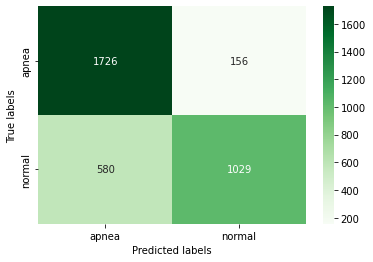

In [ ]:
check_accuracy("test", model)

## Visualizing the model's loss over epochs for both the training and test sets

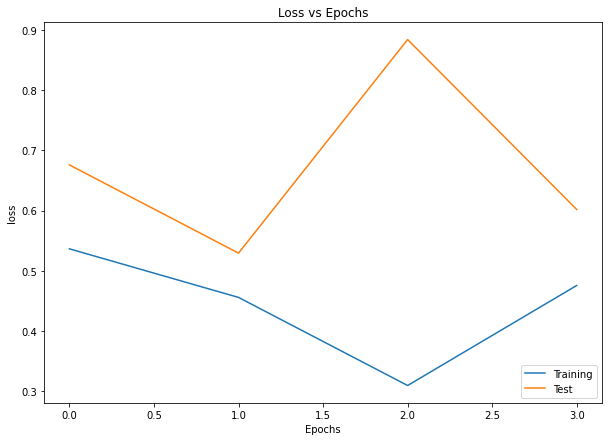

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)
fig1, ax_acc = plt.subplots()
plt.plot(losses)
plt.plot(losses_test)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['Training', 'Test'], loc='lower right')
plt.show ()

## Visualizing the model's accuracy over epochs for both the training and test sets


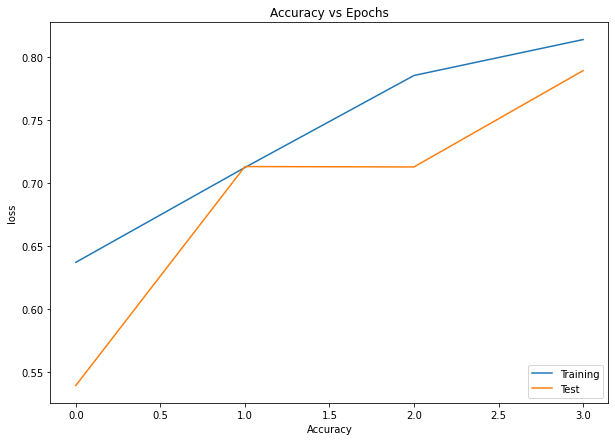

In [ ]:
fig2, ax_loss = plt.subplots()
plt.plot(accur)
plt.plot(accur_test)
plt.title('Accuracy vs Epochs')
plt.xlabel('Accuracy')
plt.ylabel('loss')
plt.legend(['Training', 'Test'], loc='lower right')
plt.show ()